
# Economic model and HJB equations


## Model specification <a id="model-spec"></a>

### State variables

| Symbol | Description | Stochastic Differential Equation |
|---|---|---|
| $\hat{k}_t = \log(K_t)$ | Productive capital | $\displaystyle dK_t = K_t\Big[ -\mu_k + \frac{I^k_t}{K_t} - \frac{\kappa}{2}\Big(\frac{I^k_t}{K_t}\Big)^2 \Big]\,dt + K_t\,\sigma_k\,dW_t$ |
| $Y_t$ | Temperature anomaly | $\displaystyle dY_t = \mathcal{E}_t\big[\bar{\theta}\,dt + \varsigma\,dW_t\big]$ |
| $\hat{r}_t = \log(R_t)$ | R&D capital | $\displaystyle dR_t = -\zeta R_t\,dt + \psi_0(I^r_t)^{\psi_1}(R_t)^{1-\psi_1}\,dt + R_t\,\sigma_r\,dW_t$ |

$W_t$ is a standard Brownian motion.

### Damage function
$$
\frac{d \hat{n}}{dy} =
\begin{cases}
\lambda_1 + \lambda_2 y, & \text{if } y \le \hat{y} \\
\lambda_1 + \lambda_2 \left( y - \hat{y} + \overline{y} \right) + \lambda_3(\ell)(y - \hat{y}), & \text{if } y > \hat{y}
\end{cases}
$$

By integration, we get

$$
\hat{n}(y) = 
\begin{cases}
\lambda_1 y + \dfrac{\lambda_2}{2} y^2, & \text{if } 0 \le y \le \hat{y} \\
\lambda_1 y + \dfrac{\lambda_2}{2} \hat{y}^2 + 
\dfrac{\lambda_2}{2} (y - \hat{y} + \overline{y})^2 + 
\dfrac{\lambda_3(\ell)}{2} (y - \hat{y})^2 - 
\dfrac{\lambda_2}{2} \overline{y}^2, & \text{if } y \ge \hat{y}
\end{cases}
$$

<iframe
  id="plotly-div"
  src="../_static/damage_interactive.html"
  width="100%"
  height="470"
  style="border:none;"
></iframe>

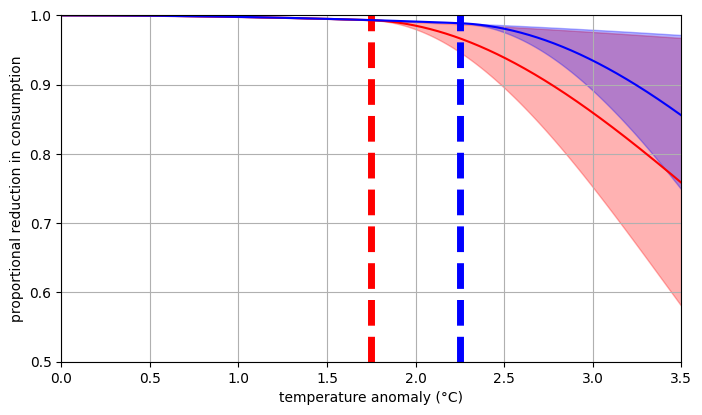

In [79]:
# --------------------------  Figure 2 of the paper (20 types of damage jump)  --------------------------
!pip -q install numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt

def plot_damage():
    Y = np.linspace(0., 3.5, 1000)
    y_underline = 1.5
    y_overline = 2.5

    gamma_1 = 0.00017675
    gamma_2 = 2 * 0.0022    
    gamma_3_list = np.linspace(0, 1. / 3, 20)

    y_limits = [1.75, 2.25]
    colors = ['red', 'blue']
    
    def y_data(y_limit):
        LHS_ylimit = np.zeros((1000,20))
        
        i=0
        for gamma_3 in gamma_3_list:
            LHS_ylimitlower = gamma_1 * Y + gamma_2/2 * Y**2 # y<y_limit
            LHS_ylimitupper = gamma_1 * Y + gamma_2*y_overline * \
                (Y-y_limit) + (gamma_2+gamma_3)/2 * \
                (Y-y_limit)**2 + gamma_2/2 * y_limit**2
        
            LHS_ylimit[:,i] =LHS_ylimitlower*(Y<y_limit) + LHS_ylimitupper*(Y>y_limit)
            i = i+1
        return LHS_ylimit

    plt.figure(figsize=(8, 4.5))

    for y_limit, color in zip(y_limits, colors):
        damages = y_data(y_limit)
        damage_upper = np.max(np.exp(-damages), axis=1)
        damage_lower = np.min(np.exp(-damages), axis=1)
        mean_damage = np.mean(np.exp(-damages), axis=1)

        plt.fill_between(Y, damage_lower, damage_upper, color=color, alpha=0.3)
        plt.plot(Y, mean_damage, color=color)
        plt.axvline(x=y_limit, color=color, linestyle="--", linewidth=5)

    plt.ylim(0.5, 1)
    plt.xlim(0, 3.5)
    plt.xlabel("temperature anomaly (°C)")
    plt.ylabel("proportional reduction in consumption")
    plt.grid(True)
    plt.show()

# Example usage:
plot_damage()


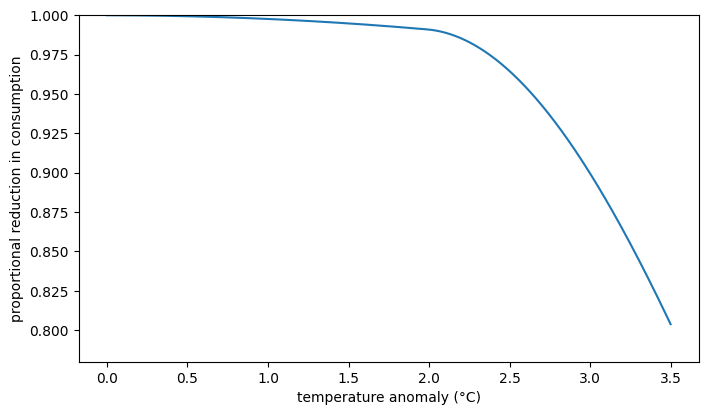

In [80]:
# --------------------------  Figure 9 of the paper (1 type of damage jump)  --------------------------
!pip -q install numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt

def plot_damage_weighted():
    # Define the temperature anomaly range
    Y = np.linspace(0., 3.5, 1000)

    # Damage function parameters
    gamma_1 = 0.00017675
    gamma_2 = 2 * 0.0022
    # 20 values of gamma_3 evenly spaced from 0 to 1/3
    gamma_3_list = np.linspace(0, 1. / 3, 20)

    g_damages_baseline = np.ones(20)


    # Piecewise function to calculate the log damage for each gamma_3:
    def y_data(y_jump, y_overline):
        # Create an array to hold damage values for each gamma_3
        LHS_yjump = np.zeros((len(Y), len(gamma_3_list)))
        for i, gamma_3 in enumerate(gamma_3_list):
            # For temperatures below y_jump
            LHS_yjump_lower = gamma_1 * Y + (gamma_2 / 2) * Y**2
            # For temperatures above y_jump
            LHS_yjump_upper = (
                gamma_1 * Y
                + gamma_2 * y_overline * (Y - y_jump)
                + (gamma_2 + gamma_3) / 2. * (Y - y_jump)**2
                + gamma_2 / 2. * y_jump**2
            )
            # Use lower function for Y < y_jump, upper for Y >= y_jump
            LHS_yjump[:, i] = np.where(Y < y_jump, LHS_yjump_lower, LHS_yjump_upper)
        return LHS_yjump

    # Example parameter choice
    y_jump, y_overline = 2., 2.5

    # Calculate the log damages across all gamma_3
    # shape: (len(Y), 20)
    log_damages = y_data(y_jump, y_overline)

    # Helper to compute weighted average log damages and exponentiate:
    def weighted_exp_damage(weights, log_damages_array):
        # We do: weighted avg = sum_i( w_i * log_damage_i ) / sum_i( w_i )
        weighted_avg_log = np.average(log_damages_array, axis=1, weights=weights)
        return np.exp(-weighted_avg_log)

    # Compute the proportional reduction for each weight set
    exp_damage_baseline    = weighted_exp_damage(g_damages_baseline, log_damages)


    # --- Plotting ---
    plt.figure(figsize=(8, 4.5))
    plt.plot(Y, exp_damage_baseline)

    plt.xlabel("temperature anomaly (°C)")
    plt.ylabel("proportional reduction in consumption")
    plt.ylim(0.78,1.0)
    plt.show()

# Example usage:
plot_damage_weighted()

$$
\mathcal{J}^n(y) = 
\begin{cases}
0, & \text{if } 0 \le y \le \underline{y} \\
\mathsf{r}_0 \exp\left[ 
\frac{\mathsf{r}_1}{2} (y - \underline{y})^2 + 
\frac{\mathsf{r}_2}{2} (y - \overline{y})^{-2}
\right] - 
\mathsf{r}_0 \exp\left[ 
\frac{\mathsf{r}_2}{2} (\underline{y} - \overline{y})^{-2}
\right], & \text{if } \underline{y} < y < \overline{y}
\end{cases}
$$

<iframe
  id="plotly-div"
  src="../_static/intensity_interactive.html"
  width="100%"
  height="420"
  style="border:none;"
></iframe>

### Controls
| Symbol | Description |
|---|---|
| $I^k_t$ | Investment in productive capital   |
| $I^r_t$ | Investment in R&D |
| $\mathcal{E}_t$ | Emission |

### Misspecifications

| Symbol | Channel | Interpretation |
|---|---|---|
| $h_k$ | Capital | Brownian motion misspecification of $K_t$ |
| $h_y$ | Climate | Brownian motion misspecification of $Y_t$ |
| $h_r$ | Knowledge | Brownian motion misspecification of $R_t$ |
| $f$ | Damage jump | Jump misspecification of damage‑jump arrival |
| $g$ | Tech jump | Jump misspecification of technology‑jump arrival |


Robustness is governed by $\{\xi_k, \xi_c, \xi_r, \xi_d, \xi_g\}$ — one for each uncertainty channel.



## Hamilton–Jacobi–Bellman Equations <a id="hjb"></a>

We distinguish four regimes:

| Case                         | Jump History        | State Vector \(x\)                        | Controls                       | Misspecification                          |
|------------------------------|---------------------|-------------------------------------------|--------------------------------|-------------------------------------------|
| (i) Post-Tech, Post-Damage  | tech ✓, damage ✓    | $\{\hat{k}\}$                             | $\{i_k\}$                      | $\{h_k\}$                                 |
| (ii) Post-Tech, Pre-Damage  | tech ✓, damage ✗    | $\{\hat{k}\}$                             | $\{i_k\}$                      | $\{h_k\}$                                 |
| (iii) Pre-Tech, Post-Damage | tech ✗, damage ✓    | $\{\hat{k},\, y,\, \hat{r}\}$             | $\{i_k,\, i_r,\, e\}$          | $\{h_k,\, h_y,\, h_r,\, g\}$              |
| (iv) Pre-Tech, Pre-Damage   | tech ✗, damage ✗    | $\{\hat{k},\, y,\, \hat{r}\}$             | $\{i_k,\, i_r,\, e\}$          | $\{h_k,\, h_y,\, h_r,\, g,\, f\}$         |

Define 

$$
\begin{align*}
    z &\overset{\mathrm{def}}{=} y - {\hat y} + {\bar y}\\
   m(z) &\overset{\mathrm{def}}{=} {\hat n}(y) - (\lambda_1{\hat y}+ \frac 1 2 \lambda_2 {\hat y} ^2)\\
   W^{\ell,L}(\hat{k},z,\hat{r}) &\overset{\mathrm{def}}{=} V^{\ell,L}(\hat{k},y,\hat{r}) + (\lambda_1{\hat y}+ \frac 1 2 \lambda_2 {\hat y} ^2)
\end{align*}
$$

then

$$
\begin{align*}
   m(z) &= \lambda_1(y - \hat{y})+{\frac 1 2}\lambda_2 (y - {\hat y} + {\bar y} )^2 + {\frac 1 2}\lambda_3(\ell) (y- \hat y)^2 - {\frac 1 2}\lambda_2(\bar y)^2\\
   &= \lambda_1(z-\bar y) +{\frac 1 2}\lambda_2z^2+{\frac 1 2}\lambda_3(\ell)(z-\bar y)^2- {\frac 1 2}\lambda_2(\bar y)^2
\end{align*}
$$

### Post-Tech, Post-Damage
We can get $W^{\ell,L}(\hat{k},z,\hat{r})$ from

$$
\begin{align*}
0 &= \max_{i^k}\,\min_{h_k}\,
    \left[\,
      \delta\log\bigl(\alpha k - i^{k}\bigr)
      - \delta W^{\ell,L}(\hat{k},z,\hat{r})
      - \delta m(z)
    \right] \\
  &\quad
    + \frac{\partial W^{\ell,L}}{\partial \hat{k}}(\hat{k},z,\hat{r})
      \left(
        -\mu_{k}
        + \frac{i^{k}}{k}
        - \frac{\kappa}{2}\!\Bigl(\frac{i^{k}}{k}\Bigr)^{2}
        - \frac{|\sigma_{k}|^{2}}{2}
        + \sigma_k\,h_k
      \right) 
    + \frac{\partial^2 W^{\ell,L}}{\partial \hat{k}^2}(\hat{k},z,\hat{r})
      \,\frac{|\sigma_{k}|^{2}}{2}\\
  &\quad
    + \frac{\xi_k}{2}\,h_k^2.
\end{align*}
$$

### Post-Tech, Pre-Damage
We can get $V^{L}(\hat{k},y,\hat{r})$ from

$$
\begin{align*}
0 &= \max_{i^k}\,\min_{h_k}\,
    \left[
      \delta \log\!\bigl(\alpha k - i^{k}\bigr)
      - \delta V^{L}(\hat{k},y,\hat{r})
      - \delta \hat n(y)
    \right] \\[6pt]
  &\quad
    + \frac{\partial V^{L}}{\partial \hat{k}}(\hat{k},y,\hat{r})
      \left(
        -\mu_{k}
        + \frac{i^{k}}{k}
        - \frac{\kappa}{2}\!\Bigl(\frac{i^{k}}{k}\Bigr)^{2}
        - \frac{|\sigma_{k}|^{2}}{2}
        + \sigma_k\,h_k
      \right) 
    + \frac{\partial^2 V^{L}}
           {\partial \hat{k}\,\partial \hat{k}'}
      (\hat{k},y,\hat{r})
      \,\frac{|\sigma_{k}|^{2}}{2}\\[6pt]
  &\quad
    + \frac{\xi_k}{2}\,h_k^2.
\end{align*}
$$
### Pre-Tech, Post-Damage
From Post-Post we know $W^{\ell,L}(\hat{k},z,\hat{r})$, then we can get $W^{\ell}(\hat{k},z,\hat{r})$ from

$$
\begin{align*}
0 &= \max_{i^k,\,i^r,\,e}\;\min_{h,\,g^{L}}\;
    \Bigl[
      \delta \log\!\bigl(\alpha k - i^{k} - i^{r}
        - \alpha k\,\phi_0\,(1 - \frac{e}{\beta \alpha k})^{\phi_1}
      \bigr)
      - \delta W^{\ell}(\hat{k},z,\hat{r})
      - \delta m(z)
    \Bigr] \\[6pt]
  &\quad
    + \frac{\partial W^{\ell}}{\partial \hat{k}}(\hat{k},z,\hat{r})
      \Bigl(
        -\mu_{k}
        + \frac{i^{k}}{k}
        - \frac{\kappa}{2}\!\bigl(\frac{i^{k}}{k}\bigr)^{2}
        - \frac{|\sigma_{k}|^{2}}{2}
        + \sigma_{k}\,h
      \Bigr)
    + \frac{\partial^2 W^{\ell}}{\partial \hat{k}\,\partial \hat{k}'}(\hat{k},z,\hat{r})
      \,\frac{|\sigma_{k}|^{2}}{2} \\[6pt]
  &\quad
    + \frac{\partial W^{\ell}}{\partial y}(\hat{k},z,\hat{r})
      \;e\;\bigl(\bar{\theta} + \varsigma\,h\bigr)
    + \frac{\partial^2 W^{\ell}}{\partial y\,\partial y'}(\hat{k},z,\hat{r})
      \;\frac{|\varsigma|^{2}}{2}\,e^{2} \\[6pt]
  &\quad
    + \frac{\partial W^{\ell}}{\partial \hat{r}}(\hat{k},z,\hat{r})
      \Bigl(
        -\zeta
        + \psi_{0}\,(i^{r})^{\psi_{1}}\,e^{-\psi_{1}\hat{r}}
        - \frac{|\sigma_{r}|^{2}}{2}
        + \sigma_{r}\,h
      \Bigr)
    + \frac{\partial^2 W^{\ell}}{\partial \hat{r}\,\partial \hat{r}'}(\hat{k},z,\hat{r})
      \,\frac{|\sigma_{r}|^{2}}{2} \\[6pt]
  &\quad
    + \mathcal{J}^{L}\,g^{L}\,
      \bigl[\,W^{\ell,L}(\hat{k},z,\hat{r}) - W^{\ell}(\hat{k},z,\hat{r})\bigr]
    + \xi\,\mathcal{J}^{L}\,\bigl[\,1 - g^{L} + g^{L}\log g^{L}\bigr] \\[6pt]
  &\quad
    + \frac{\xi}{2}\,h' h
\end{align*}
$$

### Pre-Tech, Pre-Damage
From Post-Pre we know $V^{L}(\hat{k},y,\hat{r})$,
from Pre-Post we know $W^{\ell}(\hat{k},z,\hat{r})$, so when $y=\hat{y}$, i.e. $z = \bar{y}$, we can get

$$
\begin{align*}
0 &= \max_{i^k,\,i^r,\,e}\;\min_{h,\,g^{\ell}}\;
    \Bigl[
      \delta \log\!\bigl(\alpha k - i^k - i^r
        - \alpha k\,\phi_0\,(1 - \frac{e}{\beta \alpha k})^{\phi_1}
      \bigr)
      - \delta V(\hat{k},\hat{y},\hat{r})
      - \delta \hat n(\hat{y})
    \Bigr] \\[6pt]
  &\quad
    + \frac{\partial V}{\partial \hat{k}}(\hat{k},\hat{y},\hat{r})
      \Bigl(
        -\mu_{k}
        + \frac{i^k}{k}
        - \frac{\kappa}{2}\!\bigl(\frac{i^k}{k}\bigr)^{2}
        - \frac{|\sigma_k|^2}{2}
        + \sigma_k\,h
      \Bigr)
    + \frac{\partial^2 V}{\partial \hat{k}\,\partial \hat{k}'}(\hat{k},\hat{y},\hat{r})
      \,\frac{|\sigma_k|^2}{2} \\[6pt]
  &\quad
    + \frac{\partial V}{\partial y}(\hat{k},\hat{y},\hat{r})
      \;e\;\bigl(\bar{\theta} + \varsigma\,h\bigr)
    + \frac{\partial^2 V}{\partial y\,\partial y'}(\hat{k},\hat{y},\hat{r})
      \;\frac{|\varsigma|^2}{2}\,e^2 \\[6pt]
  &\quad
    + \frac{\partial V}{\partial \hat{r}}(\hat{k},\hat{y},\hat{r})
      \Bigl(
        -\zeta
        + \psi_{0}\,(i^r)^{\psi_{1}}\,e^{-\psi_{1}\hat{r}}
        - \frac{|\sigma_r|^2}{2}
        + \sigma_r\,h
      \Bigr)
    + \frac{\partial^2 V}{\partial \hat{r}\,\partial \hat{r}'}(\hat{k},\hat{y},\hat{r})
      \,\frac{|\sigma_r|^2}{2} \\[6pt]
  &\quad
    + \sum_{\ell=1}^{L}\mathcal{J}^{\ell}\,g^{\ell}\,
      \bigl[V^{\ell}(\hat{k},\hat{y},\hat{r}) - V(\hat{k},\hat{y},\hat{r})\bigr]
    + \xi \sum_{\ell=1}^{L}\mathcal{J}^{\ell}
      \bigl[\,1 - g^{\ell} + g^{\ell}\log g^{\ell}\bigr] \\[6pt]
  &\quad
    + \frac{\xi}{2}\,h' h
\end{align*}
$$


## Computational method
### Policy iteration

For simplicity, denote the state space, control set, and distortion set by  

$$
X = \{\log k,\, y,\, \log r\}, \qquad
\Phi = \{ i^k,\, i^j,\, \mathcal{E}\}, \qquad
\Gamma = \{ h^k,\, h^y,\, h^r,\, g^\ell\}.
$$

The value function $\hat{v}(X)$ depends on the state $X$.


**Input:** initial guess $\hat{v}^0$; tolerance $\epsilon = 10^{-7}$  
**Output:** optimal value function $\hat{v}^{*}$  

1. **Initialise** $\hat{v}\leftarrow \hat{v}^0$.  
2. **Repeat**  
   1. **Step 1 (controls).** Compute optimal actions $\Phi^{*}$ from the maximisation first-order conditions using $(\hat{v},\Phi,\Gamma)$.  
   2. **Step 2 (distortions).** Compute optimal probability distortions $\Gamma^{*}$ from the minimisation first-order conditions using $(\hat{v},\Phi^{*},\Gamma)$.  
   3. **Step 3 (value update).** Obtain a provisional value $\hat{v}^{\text{new}}$ by solving (conditionally) the HJB PDE with a false-transient method, given $(\hat{v},\Phi^{*},\Gamma^{*})$.  
   4. **Step 4.** Set $\hat{v}\leftarrow\hat{v}^{\text{new}},\;\Phi\leftarrow\Phi^{*},\;\Gamma\leftarrow\Gamma^{*}$.  
3. **Until** $\lVert \hat{v}^{\text{new}}-\hat{v}\rVert < \epsilon$.

### Updating rules for $\Phi$ and $\Gamma$ at policy-improvement steps

When solving HJB equations we typically face non-linear first-order conditions
that have no closed-form solution.  
An interior **cobweb** loop is therefore embedded inside Algorithm 1:

1. Start from an initial guess for a control variable.  
2. Compute the residuals in the first-order condition.  
3. Update the control based on the residuals (optionally with relaxation).  
4. Repeat until the control converges.

Every probability distortion arising from misspecification aversion **does**
possess a closed-form expression in terms of $\hat{v}$ and its derivatives, so
those quantities are updated directly whenever $\hat{v}$ is updated.

### Solving the linear PDE at the policy-evaluation step

To update the value function we solve a **conditionally linear** PDE implicitly.  
A false-transient time dimension is introduced to stabilise the non-linear HJB;
implicit time-stepping continues until the artificial time derivative converges
to zero.  
Sparse linear systems arising at each step are solved with PETSc’s stabilised
Bi-CG method and an ILU preconditioner.

The HJB can be written as  

$$
A\,\hat{v}
+ B_{\hat{k}}\,\partial_{\hat{k}}\hat{v}
+ B_{y}\,\partial_{y}\hat{v}
+ B_{\hat{r}}\,\partial_{\hat{r}}\hat{v}
+ C_{\hat{k}}\,\partial_{\hat{k}\hat{k}}\hat{v}
+ C_{y}\,\partial_{yy}\hat{v}
+ C_{\hat{r}}\,\partial_{\hat{r}\hat{r}}\hat{v}
+ D = 0.
$$

More compactly, letting $x$ collect the state variables and $V$ denote
$\hat{v}$,

$$
0 = V_t(x) +
\mathbb{A}(x;V,V_x,V_{xx})\,V +
\mathbb{B}(x;V,V_x,V_{xx})\,V_x +
\frac12 \operatorname{tr}\!\bigl[
  \mathbb{C}(x;V,V_x,V_{xx})\,
  V_{xx}\,
  \mathbb{C}(x;V,V_x,V_{xx})
\bigr]
+ \mathbb{D}(x;V,V_x,V_{xx}).
$$

Given an iterate $V^{0}(x)$ we compute the coefficients and advance via  

$$
V^{\text{new}}(x)=
V^{0}(x)+
\Bigl[
  \mathbb{A}\,V^{0}
  + \mathbb{B}\,V^{0}_x
  + \frac12\operatorname{tr}\!\bigl(\mathbb{C}\,V^{0}_{xx}\,\mathbb{C}\bigr)
  + \mathbb{D}
\Bigr]\Delta t ,
$$

then solve the resulting linear system with Bi-CG-Stab.

See [**`PostSolver.py`**](https://github.com/korito1416/two-capital-climate-change/blob/new_model_boundary/python/src/PostSolver_new_rho1.py) and [**`PreSolver.py`**](https://github.com/korito1416/two-capital-climate-change/blob/new_model_boundary/python/src/PreSolver_CRS2_new_rho1.py) for code.

### Finite-difference scheme

* **Interior points** — central differences  

  $$
    \left(\frac{\partial f}{\partial x}\right)_i
      = \frac{f_{i+1}-f_{i-1}}{2\Delta x},
  \qquad
    \left(\frac{\partial^2 f}{\partial x^2}\right)_i
      = \frac{f_{i+1}+f_{i-1}-2f_i}{\Delta x^2}.
  $$

* **Lower boundary** — forward differences  

  $$
    \left(\frac{\partial f}{\partial x}\right)_0
      = \frac{f_{1}-f_{0}}{\Delta x},
  \qquad
    \left(\frac{\partial^2 f}{\partial x^2}\right)_0
      = \frac{f_{2}+f_{0}-2f_{1}}{\Delta x^2}.
  $$

* **Upper boundary** — backward differences  

  $$
    \left(\frac{\partial f}{\partial x}\right)_{N-1}
      = \frac{f_{N-1}-f_{N-2}}{\Delta x},
  \qquad
    \left(\frac{\partial^2 f}{\partial x^2}\right)_{N-1}
      = \frac{f_{N-1}+f_{N-3}-2f_{N-2}}{\Delta x^2}.
  $$

See [**`Utility.py`**](https://github.com/korito1416/two-capital-climate-change/blob/new_model_boundary/python/src/Utility.py) for code.


## Solution

Production runs are scripted:

* [**`Postdamage.sh`**](https://github.com/korito1416/two-capital-climate-change/blob/new_model_boundary/conduction/Postdamage_NewPlug.sh) – solves post‑damage regimes with random initialization
* [**`Postdamage_sub.sh`**](https://github.com/korito1416/two-capital-climate-change/blob/new_model_boundary/conduction/Postdamage_sub_NewPlug.sh) – grid‑refinement loop to accelerate convergence  
* [**`Predamage.sh`**](https://github.com/korito1416/two-capital-climate-change/blob/new_model_boundary/conduction/Predamage.sh) – solves pre‑damage regimes  


<style>
  .btn-group {
    display: inline-flex;
    gap: 0.5em;
    margin-bottom: 1em;
  }
  .btn-group button {
    padding: 0.5em 1em;
    border: 2px solid #007acc;
    background: white;
    color: #007acc;
    font-size: 1rem;
    border-radius: 0.5em;
    cursor: pointer;
    transition: background 0.2s, color 0.2s;
  }
  .btn-group button.active,
  .btn-group button:hover {
    background: #007acc;
    color: white;
  }
  .plot-container {
    margin-top: 1em;
  }
</style>

<div class="btn-group">
  <button data-target="xik0.05" class="active">More aversion</button>
  <button data-target="xik0.1">Less aversion</button>
  <button data-target="xik1e5">Baseline</button>
</div>

<div id="plot-xik0.05" class="plot-container">
  <iframe src="../_static/df_V_m3_surface_xik0.05.html"
          width="100%" height="470" style="border:none;"></iframe>
</div>
<div id="plot-xik0.1" class="plot-container" style="display:none;">
  <iframe src="../_static/df_V_m3_surface_xik0.1.html"
          width="100%" height="470" style="border:none;"></iframe>
</div>
<div id="plot-xik1e5" class="plot-container" style="display:none;">
  <iframe src="../_static/df_V_m3_surface_xik1e+05.html"
          width="100%" height="470" style="border:none;"></iframe>
</div>

<script>
  const buttons = document.querySelectorAll('.btn-group button');
  buttons.forEach(btn => {
    btn.addEventListener('click', () => {
      // toggle active class
      buttons.forEach(b => b.classList.remove('active'));
      btn.classList.add('active');
      // show the right plot
      const sel = btn.getAttribute('data-target');
      ['xik0.05','xik0.1','xik1e5'].forEach(id => {
        document.getElementById('plot-'+id).style.display =
          (id === sel ? 'block' : 'none');
      });
    });
  });
</script>
